In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from sklearn.metrics import mean_squared_error

%matplotlib notebook

In [2]:
data_folder=("/home/alessandro/Scrivania/University/ML4ECAL/Transparency/DataPreparation")

In [3]:
#Read metadata
metadata = pd.read_csv(f"{data_folder}/fill_metadata_2017_10min.csv")

In [4]:
#Load data
data = np.load(f"{data_folder}/iring_25.npy")
data_test = np.load(f"{data_folder}/iring_26.npy")
data_test_2 = np.load(f"{data_folder}/iring_24.npy")

data_df = pd.DataFrame(data)
data_df_test = pd.DataFrame(data_test)
data_df_test_2 = pd.DataFrame(data_test_2)

In [5]:
#Mean transparency in iRing
mean = []
mean_test = []
mean_test_2 = []
for i in range(0, len(data_df.axes[1])):
    mean = np.append(mean, np.mean(data_df[i]))
    mean_test = np.append(mean_test, np.mean(data_df_test[i]))
    mean_test_2 = np.append(mean_test_2, np.mean(data_df_test_2[i]))

In [6]:
#Filter data and metadata
mean = mean[mean != -1]
mean_test = mean_test[mean_test != -1]
mean_test_2 = mean_test_2[mean_test_2 != -1]
metadata = metadata.iloc[:len(mean)][mean != -1]

In [7]:
def fit_func2(data, a, b, c, d, e, f):
    x = data[0]
    y = data[1]
    y_0 = data[2]
    return (a*np.exp(-b*x)+(1-a)*np.exp(c*x))*(d*np.exp(-e*y)+(1-d)*np.exp(f*y))/(d*np.exp(-e*y_0)+(1-d)*np.exp(f*y_0))

In [8]:
def fit_func1(data, a, b, c, d, e, f):
    x = data[0]
    y = data[1]
    y_0 = data[2]
    return (a*np.exp(-b*x)+(1-a)*np.exp(c*x))*(d*np.exp(-e*(y-y_0))+(1-d)*np.exp(f*(y-y_0)))

# Fitting

In [9]:
fill = metadata["fill_num"].unique()
fill = fill[fill != 0]

In [10]:
metadata_fill = metadata[metadata.fill_num.isin(fill)]
metadata_fill = metadata_fill[(metadata_fill.lumi_inst >= 0.0001*1e9) & (metadata_fill.lumi_inst <= 0.0004*1e9) & (metadata_fill.lumi_in_fill >= 0.1*1e9)]

In [11]:
fill_num = metadata_fill.fill_num.unique()
transp_fill = []
lumi_inst_0 = []
lumi_int_0 = []

for k in fill_num:
    df = metadata_fill[metadata_fill.fill_num == k]
    transp = [mean[i] for i in df.index.values]
    transp = transp/transp[0]
    transp_fill = np.append(transp_fill, transp)
    a = np.empty(np.size(transp))
    b = np.empty(np.size(transp))
    a.fill(df['lumi_inst'].iloc[0])
    b.fill(df['lumi_int'].iloc[0])
    lumi_inst_0 = np.append(lumi_inst_0, a)
    lumi_int_0 = np.append(lumi_int_0, b)

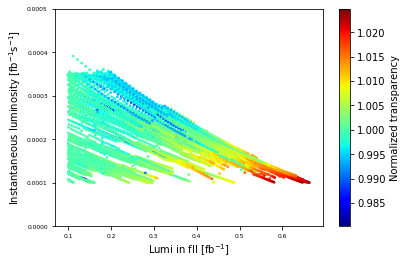

In [12]:
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=transp_fill, cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
#plt.clim(0.97, 1.20)
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$s$^{-1}$]")
cbar.set_label("Normalized transparency")
#plt.savefig("fill")

## Function #1

In [13]:
#Fit function #1
par1, pcov1 = curve_fit(fit_func1, [metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], transp_fill, maxfev=5000)

In [ ]:
#RMSE
np.sqrt(mean_squared_error(transp_fill, fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], *par1)))

In [ ]:
#Plot fit function #1
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par1), cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$s$^{-1}$]")
cbar.set_label("Fit function")
#plt.savefig("fill_fit1")

In [ ]:
#Plot transp_fill-fit_function #1
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=transp_fill-fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par1), cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("Observed-Predicted")
#plt.savefig("fill_fit1_bias")

In [ ]:
#Plot (transp_fill-fit_function #1)/transp-fill
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=(transp_fill-fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par1))/transp_fill, cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$s$^{-1}$]")
cbar.set_label("(Observed-Predicted)/Observed")
#plt.savefig("fill_fit1_bias_normalized")

In [ ]:
#Plot vs lumi_in_fill
plt.plot(metadata_fill.lumi_in_fill*(1e-9), transp_fill,".r", label="Observed")
plt.plot(metadata_fill.lumi_in_fill*(1e-9), fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], *par1), ".b", label="Predicted")
plt.xlabel("Lumi in fill [fb$^{-1}$]")
plt.ylabel("Normalized mean transparency")
#plt.savefig("fit1_vs_lumi_in_fill")

## Function #2

In [ ]:
#Fit function #2
par2, pcov2 = curve_fit(fit_func2, [metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], transp_fill, maxfev=5000)

In [ ]:
#RMSE
np.sqrt(mean_squared_error(transp_fill, fit_func2([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], *par2)))

In [ ]:
#Plot fit function #2
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=fit_func2([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], *par2), cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("Fit function")
#plt.savefig("fill_fit2")

In [ ]:
#Plot transp_fill-fit_function #2
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=transp_fill-fit_func2([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par2), cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("Observed-Predicted")
#plt.savefig("fill_fit2_bias")

In [ ]:
#Plot (transp_fill-fit_function #2)/transp-fill
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=(transp_fill-fit_func2([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par2))/transp_fill, cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("(Observed-Predicted)/Observed")
#plt.savefig("fill_fit2_bias_normalized")

In [ ]:
#Plot vs lumi_in_fill
plt.plot(metadata_fill.lumi_in_fill*(1e-9), transp_fill,".r", label="Observed")
plt.plot(metadata_fill.lumi_in_fill*(1e-9), fit_func2([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], *par2), ".b", label="Predicted")
plt.xlabel("Lumi in fill [fb$^{-1}$]")
plt.ylabel("Normalized mean transparency")
#plt.savefig("fit2_vs_lumi_in_fill")

# Test (iRing 24)

In [ ]:
transp_fill = []
for k in fill_num:
    df = metadata_fill[metadata_fill.fill_num == k]
    transp = [mean_test_2[i] for i in df.index.values]
    transp = transp/transp[0]
    transp_fill = np.append(transp_fill, transp)

In [ ]:
#RMSE
np.sqrt(mean_squared_error(transp_fill, fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], *par1)))

In [ ]:
# Plot fit function #1
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=transp_fill-fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par1), cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$s$^{-1}$]")
cbar.set_label("Observed-Predicted")
#plt.savefig("fill_fit1_test_bias")

In [ ]:
# Plot fit function #1
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=(transp_fill-fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par1))/transp_fill, cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$s$^{-1}$]")
cbar.set_label("(Observed-Predicted)/Observed")
#plt.savefig("fill_fit1_test_bias_normalized")

In [ ]:
#Plot vs lumi_in_fill
plt.plot(metadata_fill.lumi_in_fill*(1e-9), transp_fill,".r", label="Observed")
plt.plot(metadata_fill.lumi_in_fill*(1e-9), fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], *par2), ".b", label="Predicted")
plt.xlabel("Lumi in fill [fb$^{-1}$]")
plt.ylabel("Normalized mean transparency")
#plt.savefig("fit2_vs_lumi_in_fill")

In [ ]:
# Plot fit function #2
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=transp_fill-fit_func2([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par2), cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("Observed-Predicted")
#plt.savefig("fill_fit2_test_bias")

In [ ]:
# Plot fit function #2
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=(transp_fill-fit_func2([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par2))/transp_fill, cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("(Observed-Predicted)/Observed")
#plt.savefig("fill_fit2_test_bias_normalized")

## Test (iRing 26)

In [ ]:
transp_fill = []
for k in fill_num:
    df = metadata_fill[metadata_fill.fill_num == k]
    transp = [mean_test[i] for i in df.index.values]
    transp = transp/transp[0]
    transp_fill = np.append(transp_fill, transp)

In [ ]:
#RMSE
np.sqrt(mean_squared_error(transp_fill, fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), lumi_inst_0*(1e-9)], *par1)))

In [ ]:
# Plot fit function #1
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=transp_fill-fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par1), cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("Observed-Predicted")
#plt.savefig("fill_fit1_test2_bias")

In [ ]:
# Plot fit function #1
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=(transp_fill-fit_func1([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par1))/transp_fill, cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("(Observed-Predicted)/Observed")
#plt.savefig("fill_fit1_test2_bias_normalized")

In [ ]:
# Plot fit function #2
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=transp_fill-fit_func2([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par2), cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("Observed-Predicted")
#plt.savefig("fill_fit2_test2_bias")

In [ ]:
# Plot fit function #2
plt.scatter(metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9), c=(transp_fill-fit_func2([metadata_fill.lumi_in_fill*(1e-9), metadata_fill.lumi_inst*(1e-9),lumi_inst_0*(1e-9)], *par2))/transp_fill, cmap='jet', s=3)
plt.ylim(0, 0.0005)
cbar = plt.colorbar()
plt.tick_params(labelsize=6)
plt.xlabel("Lumi in fll [fb$^{-1}$]")
plt.ylabel("Instantaneous luminosity [fb$^{-1}$]")
cbar.set_label("(Observed-Predicted)/Observed")
#plt.savefig("fill_fit2-test2_bias_normalized")